In [38]:
from ultralytics import YOLO
import numpy as np
from PIL import Image
import cv2
import colorsys
import random
import pandas as pd

In [39]:
model = YOLO("D:/Yolo8-segmentation/train_x 643/weights/best.pt")  # load a custom model

img = cv2.imread("D:/Clean_Dataset/vgg/train/131.jpg")

In [40]:
def detect(model, img):
        # Get img shape
    height, width, channels = img.shape
    results = model.predict(source=img.copy(), project="D:/Clean_Dataset/Yolo8_result", name="saq", imgsz=1920, save=True, iou=0.5, conf=0.2, save_txt=False)
    result = results[0]
    segments = []
    total_area= []
    for x in result.masks.cpu().data.numpy().astype('uint8'):
        c = cv2.findContours(x, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[0]
        contour_areas = []
        for contour in c:
            area = cv2.contourArea(contour)
            contour_areas.append(area)
        combined_area = sum(contour_areas)
        c = np.concatenate([x.reshape(-1, 2) for x in c])
        segments.append(c.astype('float32'))
        total_area.append(combined_area)
        

    bboxes = np.array(result.boxes.xyxy.cpu(), dtype="int")
        # Get class ids
    class_ids = np.array(result.boxes.cls.cpu(), dtype="int")
        # Get scores
    scores = np.array(result.boxes.conf.cpu(), dtype="float").round(2)
    #print(class_ids)
    return bboxes, class_ids, segments, scores, total_area

In [41]:
def draw_mask(img, pts, color, alpha=0.5):
    h, w, _ = img.shape

    overlay = img.copy()
    output = img.copy()

    pts_list = [np.array(pts, dtype=np.int32)]  # Convert the input `pts` to the correct format
    cv2.fillPoly(overlay, pts_list, color)
    output = cv2.addWeighted(overlay, alpha, output, 1 - alpha, 0, output)
    return output

In [42]:
def random_colors(N, bright=True):
    """
    Generate random colors.
    To get visually distinct colors, generate them in HSV space then
    convert to RGB.
    """
    brightness = 255 if bright else 180
    hsv = [(i / N + 1, 1, brightness) for i in range(N + 1)]
    colors = list(map(lambda c: colorsys.hsv_to_rgb(*c), hsv))
    random.shuffle(colors)
    return colors 

In [43]:
class_names = ['Fibre', 'Vessel']
colors = random_colors(len(class_names))
list2=[]

In [44]:
bboxes, classes, segmentations, scores, area = detect(model, img)
for bbox, class_id, seg, score, area in zip(bboxes, classes, segmentations, scores, area):
    # print("bbox:", bbox, "class id:", class_id, "seg:", seg, "score:", score)
    (x, y, x2, y2) = bbox
    rect = cv2.minAreaRect(seg)
    box1 = cv2.boxPoints(rect)
    box1 = np.int0(box1)
    #print(box1)
    a,b,c,d=box1
    dst1= ((a[0] - b[0])**2 + (a[1] - b[1])**2)**0.5
    dst2 = ((b[0] - c[0])**2 + (b[1] - c[1])**2)**0.5
    dst1 = dst1 * 0.65
    dst2 = dst2 * 0.65
    if dst1 > dst2:
      Length = dst1
    else:
      Length = dst2
    #area_px = cv2.contourArea(seg)
    area_px = area * 0.65
    Width = round(area_px/Length, 2)
    list1 = class_names[class_id], Length, Width, area_px
    list2.append(list1)
    
    
    #cv2.drawContours(img, [seg], 0, (0, 255, 0), 2)
    #cv2.drawContours(img, [bbox], 0, (0, 0, 255), 2)
    #cv2.rectangle(img, (x, y), (x2, y2), colors[class_id], 2)
    img = draw_mask(img, [seg], colors[class_id])
    #cv2.rectangle(img, (a, b), (c, d), (255, 0, 0), 2)
    cv2.drawContours(img,[box1],0, (255, 0, 255),2)
    


0: 1440x1920 5 fibres, 1 vessel, 8410.9ms
Speed: 26.0ms preprocess, 8410.9ms inference, 28.1ms postprocess per image at shape (1, 3, 1920, 1920)
Results saved to D:\Clean_Dataset\Yolo8_result\saq22


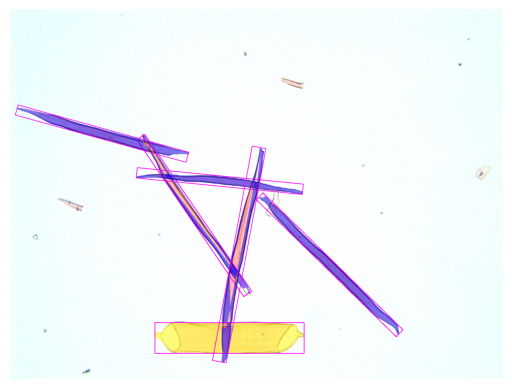

In [45]:
import matplotlib.pyplot as plt
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis('off')  # Turn off the axis labels
plt.show()

In [9]:
df = pd.DataFrame(list2)
df1 = df.rename(columns={0: 'Class Name',1: 'Length', 2: 'Width', 3: 'Area'})
df1.to_excel("D:/Clean_Dataset/Yolo8_result/output.xlsx")

In [ ]:
-